# Figure 1, but for Proxima Centauri b.

Overview of the model set-up for the Proxima b case. The *MassFlux* simulation covers the whole sphere, while the *HighRes* simulation is shown by superimposing a high-resolution grid that covers only the substellar region. The graphic shows cloud condensate (white isosurfaces), surface temperature (shading), and free troposphere wind vectors (arrows), focusing on (a) the day side, with the *HighRes* model domain and the cloud condensate isosurface, and (b) the night side of the planet. The cloud condensate is shown using a threshold of $10^{-5}~kg~kg^{-1}$ of total cloud condensate (liquid water plus ice). This figure is available online as an interactive zoom and rotatable figure.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

## Import necessary libraries

Standard library

In [1]:
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

3D visualization and mesh analysis library

In [2]:
import pyvista as pv

Scientific stack

In [3]:
import iris
import numpy as np

In [4]:
from aeolus.const import init_const
from aeolus.plot import subplot_label_generator
from aeolus.plot.pv import grid_for_scalar_cube_sph, grid_for_vector_cubes_sph

Set white background for 3d figures.

In [5]:
pv.set_plot_theme("document")

Global definitions.

## Load data

In [6]:
const = init_const("proxb")

In [7]:
datadir = Path.cwd() / "data"

In [8]:
dset_global = iris.load(datadir / "proxb_global_t_sfc_u_v_w_cld_liq_mf_cld_ice_mf.nc")
dset_lam = iris.load(datadir / "proxb_lam_cld_mf.nc")

## Create `pyvista` objects for a composite plot

Set cloud condensate isosurface threshold.

In [9]:
CC_ISOSURF = [1e-5]  # [kg kg-1]
RADIUS = float(const.radius.data)  # Planet radius [m]
RADIUS

7160000.0

Set viewpoints.

In [10]:
CAM_POS_LATS = [10, 20]
CAM_POS_LONS = [30, 120]

### Global

Set common visualisation propeties.

In [11]:
z_scale = 100.0
z_offset = RADIUS * 1.01

Create a grid for the surface temperature.

In [12]:
t_sfc = dset_global.extract_cube("surface_temperature")

grid_sfc = grid_for_scalar_cube_sph(t_sfc, z_offset=z_offset, label="global_sfc_grid")

Extract 3 wind components from the global model output.

In [13]:
wind_levels = [5000]  # [m]

winds = dset_global.extract(
    iris.Constraint(level_height=lambda x: x in wind_levels)
).extract(["x_wind", "y_wind", "upward_air_velocity"])

Create a grid for the wind vectors.

In [14]:
grid_vec = grid_for_vector_cubes_sph(
    *winds,
    vector_scale=RADIUS * 0.004,
    vertical_wind_scale=1e2,
    z_scale=z_scale,
    z_offset=z_offset,
    xstride=1,
    ystride=1,
    label="global_wind_vectors_grid",
)

In [15]:
grid_vec

StructuredGrid (0x7eff74d36ec0)
  N Cells:      27313
  N Points:     27648
  X Bounds:     -7.736e+06, 7.736e+06
  Y Bounds:     -7.736e+06, 7.736e+06
  Z Bounds:     -7.737e+06, 7.737e+06
  Dimensions:   144, 192, 1
  N Arrays:     1

Create glyph objects to show wind vectors.

In [16]:
glyphs = grid_vec.glyph(
    orient="global_wind_vectors_grid",
    scale="global_wind_vectors_grid",
    tolerance=0.035,
)

Extract the total cloud condensate.

In [17]:
global_qct = sum(
    dset_global.extract_cubes(
        [
            "mass_fraction_of_cloud_liquid_water_in_air",
            "mass_fraction_of_cloud_ice_in_air",
        ]
    )
)

Create a grid for the cloud condensate and extract a 3D contour (isosurface).

In [18]:
global_qct_cntr = (
    grid_for_scalar_cube_sph(
        global_qct, z_scale=z_scale, z_offset=z_offset, label="global_qct_grid"
    )
    .cell_data_to_point_data()
    .contour(isosurfaces=CC_ISOSURF)
)

### HighRes

Set common visualisation propeties.

In [19]:
z_scale = 120.0
z_offset = RADIUS * 1.02
# TOPLEV = 60
# DLEV = 2  # use every 2nd level
# DY = 3  # stride along y-coordinate
# DX = 3  # stride along x-coordinate

Extract the total cloud condensate from the *HighRes* simulation.

In [20]:
lam_qct = dset_lam.extract_cube(
    "mass_fraction_of_cloud_condensed_water_in_air",
)

Create a grid from the 3D total cloud condensate field.

In [21]:
lam_grid = grid_for_scalar_cube_sph(
    lam_qct,
    z_scale=z_scale,
    z_offset=z_offset,
    label="lam_qct_grid",
)

Create an isosurface of the cloud condensate.

In [22]:
lam_qct_cntr = lam_grid.cell_data_to_point_data().contour(isosurfaces=CC_ISOSURF)

Extract a mesh from the HighRes data.

In [23]:
lam_dom = (
    grid_for_scalar_cube_sph(
        lam_qct[:, ::7, ::7],
        z_scale=z_scale,
        z_offset=z_offset,
        label="lam_dom",
    )
    .extract_geometry()
    .extract_all_edges()
)

## Prepare data for plotting

Pack grids and plotting arguments into a single list.

In [24]:
VIS_CONTAINER = [
    {
        # Global surface temperature
        "mesh": grid_sfc,
        "kwargs": {
            "cmap": "plasma",
            "clim": [160, 285],
            "show_scalar_bar": False,
            "smooth_shading": True,
        },
    },
    {
        # Global wind vectors
        "mesh": glyphs,
        "kwargs": {"cmap": "Greys", "scalars": "GlyphScale", "show_scalar_bar": False},
    },
    {
        # Global cloud condensate
        "mesh": global_qct_cntr,
        "kwargs": {
            "color": "#ededff",
            "clim": [1e-05, 1e-05],
            "opacity": 0.5,
            "show_scalar_bar": False,
            "smooth_shading": True,
        },
    },
    {
        # HighRes cloud condensate
        "mesh": lam_qct_cntr,
        "kwargs": {
            "color": "#ebebff",
            "clim": [1e-05, 1e-05],
            "opacity": 1.0,
            "show_scalar_bar": False,
            "specular": 0.5,
            "ambient": 0.5,
            "smooth_shading": True,
        },
    },
    {
        # HighRes domain edges
        "mesh": lam_dom,
        "kwargs": {
            "style": "wireframe",
            "color": "k",
            "opacity": 0.2,
            "smooth_shading": True,
        },
    },
]

## Plot the results

Assemble the plot.

In [25]:
iletters = subplot_label_generator()

p = pv.Plotter(shape=(1, len(CAM_POS_LONS)), window_size=np.array([1024, 768 // 2]) * 2)

for idx, (cam_lon, cam_lat) in enumerate(zip(CAM_POS_LONS, CAM_POS_LATS)):
    p.subplot(0, idx)

    p.add_text(f"({next(iletters)})", font="times", font_size=24)

    for plot_dict in VIS_CONTAINER:
        p.add_mesh(plot_dict["mesh"], **plot_dict["kwargs"])

    p.set_position(pv.grid_from_sph_coords([cam_lon], [90 - cam_lat], [4.5e7]).points)
    p.set_focus((0, 0, 0))
    p.set_viewup((0, 0, 1))

## Show the figure

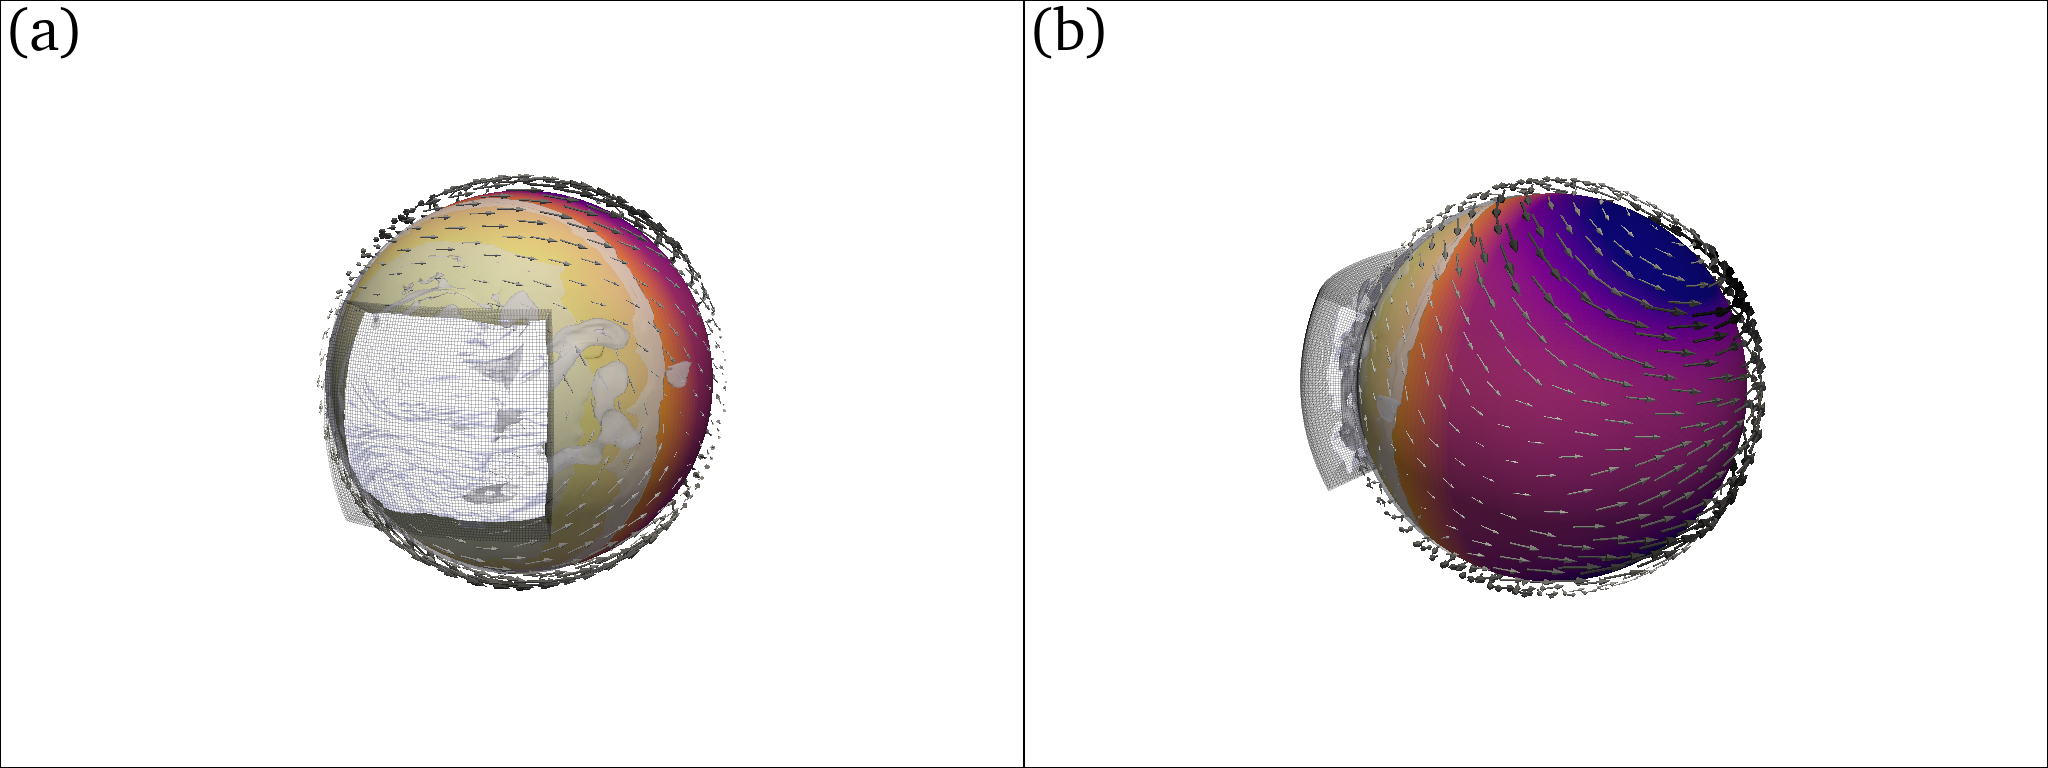

In [26]:
p.show(jupyter_backend="static")